https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [1]:
from google.colab import drive
import os

In [2]:
drive.mount('drive')
os.chdir('drive/My Drive/Health Insurance Cross Sell Prediction/')

Mounted at drive


In [3]:
os.listdir()

['archive.zip', 'sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
from zipfile import ZipFile
filename ='archive.zip'
archive = ZipFile(filename)
archive.extractall()

In [5]:
os.listdir()

['archive.zip', 'sample_submission.csv', 'test.csv', 'train.csv']

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## EDA

In [8]:
print('Shape: {}'.format(train.shape))
train.head()

Shape: (381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [10]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


#### Data description
* id - Unique ID for the customer
* Gender - Gender of the customer
* Age - Age of the customer
* Driving_License	- 0 : Customer does not have DL, 1 : Customer already has DL
* Region_Code - Unique code for the region of the customer
* Previously_Insured - 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age -	Age of the Vehicle
* Vehicle_Damage - 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium - The amount customer needs to pay as premium in the year
* PolicySalesChannel - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage - Number of Days, Customer has been associated with the company
* Response - 1 : Customer is interested, 0 : Customer is not interested

In [11]:
binary = ['Gender', 'Driving_License', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured']
categorical = ['Region_Code', 'Policy_Sales_Channel', 'Vintage']
numerical = ['Age', 'Annual_Premium']

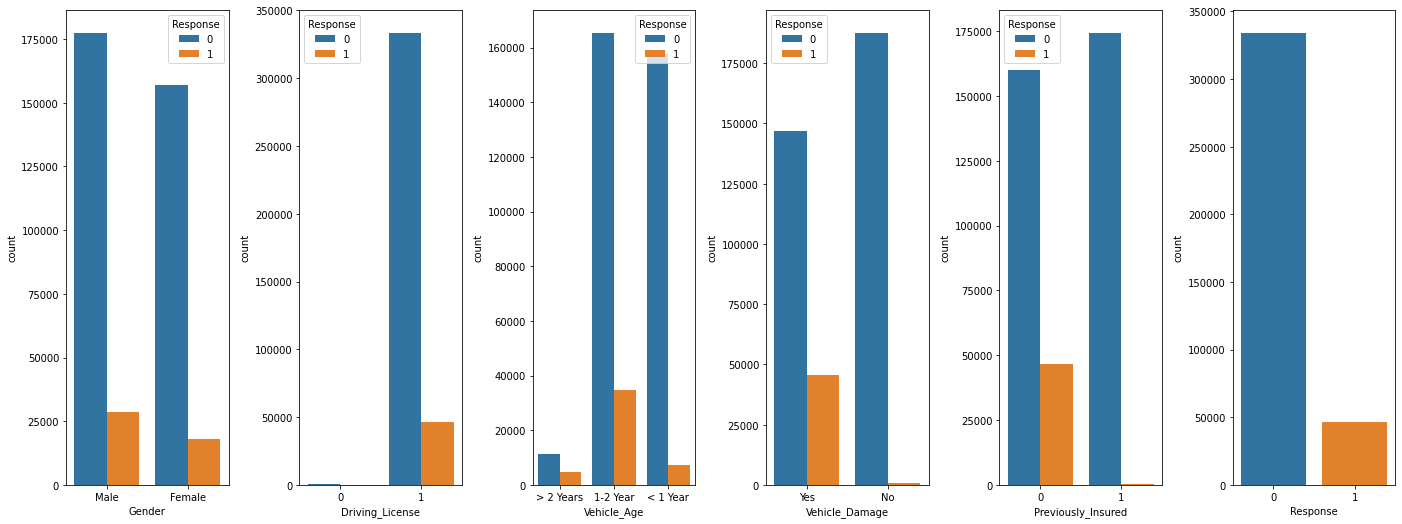

In [12]:
fig, axs = plt.subplots(1, len(binary) + 1, figsize=(20, 8))
fig.tight_layout(pad=4.0)
for i, column in enumerate(binary):
  sns.countplot(x=column, data=train, hue='Response', ax=axs[i])

sns.countplot(x='Response', data=train, ax=axs[-1])

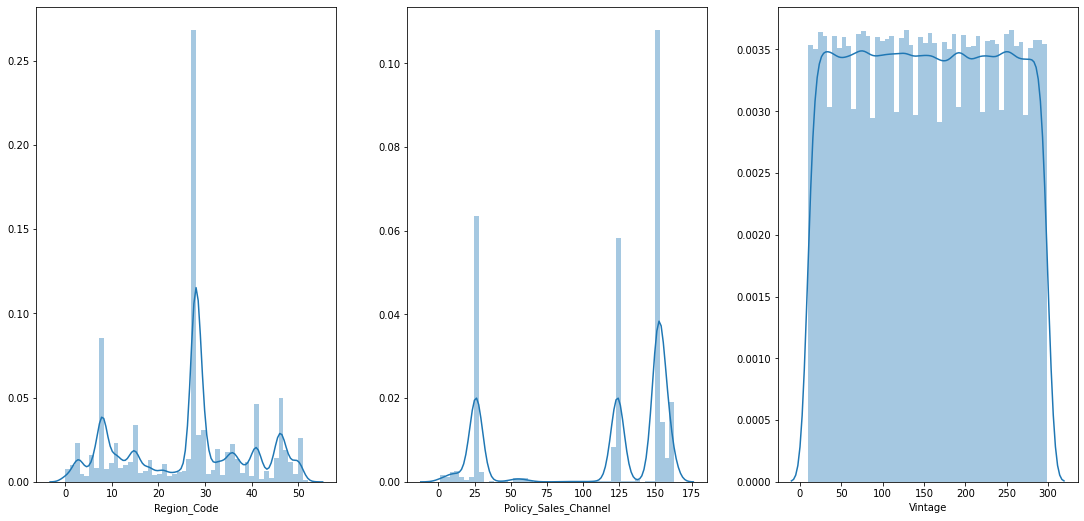

In [13]:
fig, axs = plt.subplots(1, len(categorical), figsize=(16, 8))
fig.tight_layout(pad=4.0)
for i, column in enumerate(categorical):
  sns.distplot(train[column], ax=axs[i])

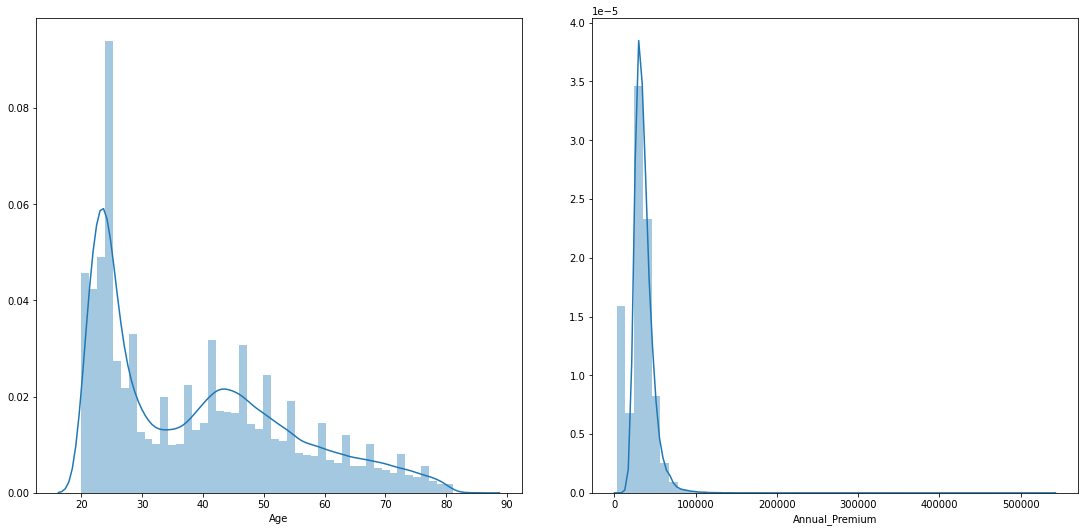

In [14]:
fig, axs = plt.subplots(1, len(numerical), figsize=(16, 8))
fig.tight_layout(pad=4.0)
for i, column in enumerate(numerical):
  sns.distplot(train[column], ax=axs[i])

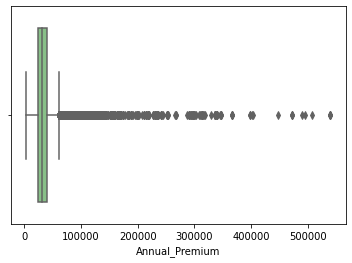

In [18]:
sns.boxplot(x='Annual_Premium', data=train, palette='Accent')

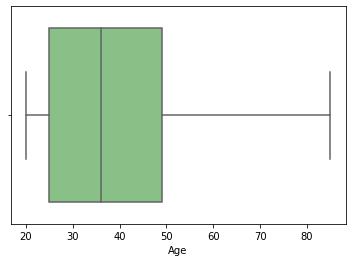

In [19]:
sns.boxplot(x='Age', data=train, palette='Accent')

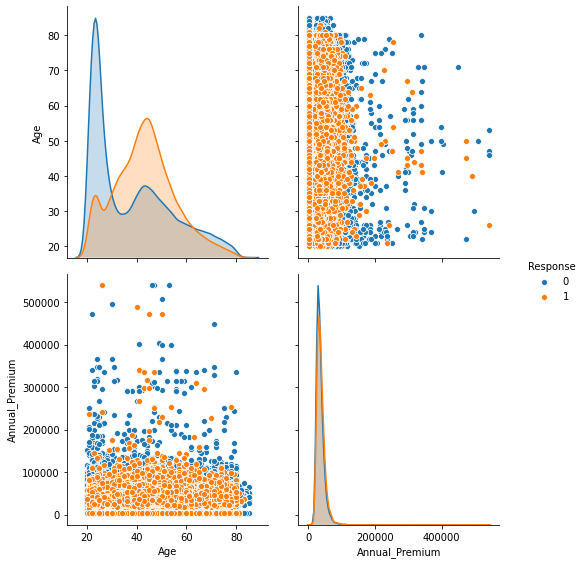

In [15]:
g = sns.pairplot(train[['Age', 'Annual_Premium', 'Response']], hue='Response')
g.fig.set_size_inches(8,8)

## Data preprocessing

In [54]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [55]:
def data_preprocessing(data):
  df = data.copy()

  to_drop = ['id', 'Gender', 'Vehicle_Age']

  df['Is_Male'] = df['Gender'].map({'Female':0, 'Male':1})
  df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes':1})

  df['Region_Code'] = df['Region_Code'].astype('int64')
  df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64')

  dummy_features = pd.get_dummies(df['Vehicle_Age'])
  df = pd.concat([df, dummy_features], axis=1)

  df = df.drop(to_drop, axis=1)

  df = df.rename(columns={'1-2 Year':'Year_btw_1_2', '< 1 Year':'Year_sm_1', '> 2 Years':'Year_gt_2'})
  return df

In [56]:
train = data_preprocessing(train)
test = data_preprocessing(test)

In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
train[['Age', 'Vintage']] = scaler.fit_transform(train[['Age', 'Vintage']])
min_max_scaler = MinMaxScaler()
train['Annual_Premium'] = min_max_scaler.fit_transform(train['Annual_Premium'].values.reshape(-1, 1))

test[['Age', 'Vintage']] = scaler.transform(test[['Age', 'Vintage']])
test['Annual_Premium'] = min_max_scaler.transform(test['Annual_Premium'].values.reshape(-1,1))

In [58]:
train.head(3)

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Is_Male,Year_btw_1_2,Year_sm_1,Year_gt_2
0,0.333777,1,28,0,1,0.070366,26,0.748795,1,1,0,0,1
1,2.396751,1,3,0,0,0.057496,26,0.342443,0,1,1,0,0
2,0.527181,1,28,0,1,0.066347,26,-1.521998,1,1,0,0,1


In [59]:
test.head(3)

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Is_Male,Year_btw_1_2,Year_sm_1,Year_gt_2
0,-0.891113,1,11,1,0,0.061682,152,-1.211258,1,0,1,0
1,0.075906,1,28,0,1,0.057916,7,-0.518068,1,1,0,0
2,0.527181,1,28,0,1,0.069614,124,0.533668,1,1,0,0


## Modeling

In [64]:
from sklearn.model_selection import train_test_split

x_train = train.drop(['Response'], axis=1)
y_train = train['Response']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, auc

model = XGBClassifier()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))

Accuracy score: 0.8750623179659416


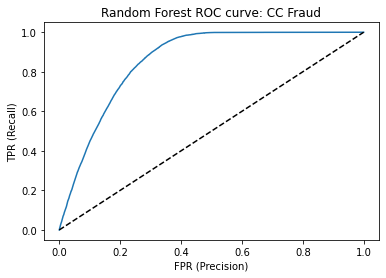

Area under curve (AUC):  0.8584111734686132


In [69]:
y_score = model.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
plt.title('Random Forest ROC curve: CC Fraud')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))